# 决策树自主实践与Sklearn调用
## Part one：复现实践材料
### 导入实验中的相关包

In [2]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from math import log
import operator
import pickle

### 2.构建简单的分类数据集

In [3]:
def createDataSet():
    dataSet =  [[0, 0, 0, 0, 'no'],
                [0, 0, 0, 1, 'no'],
                [0, 1, 0, 1, 'yes'],
                [0, 1, 1, 0, 'yes'],
                [0, 0, 0, 0, 'no'],
                [1, 0, 0, 0, 'no'],
                [1, 0, 0, 1, 'no'],
                [1, 1, 1, 1, 'yes'],
                [1, 0, 1, 2, 'yes'],
                [1, 0, 1, 2, 'yes'],
                [2, 0, 1, 2, 'yes'],
                [2, 0, 1, 1, 'yes'],
                [2, 1, 0, 1, 'yes'],
                [2, 1, 0, 2, 'yes'],
                [2, 0, 0, 0, 'no']]
    #分类属性
    labels = ['年龄','有工作','有自己的房子','信贷情况']
    #返回数据集和分类属性
    return dataSet, labels

### 3.计算香农熵函数

In [4]:
def calcShannonEnt(dataSet):
    # 返回数据集的行数
    numEntries = len(dataSet)
    # 保存每个标签出现次数的字典
    labelCounts = {}
    # 对每组特征向量进行统计
    for featVec in dataSet:
        # 提取标签信息
        currentLabel = featVec[-1]
        # 如果标签没有放入统计次数的字典，则添加
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        # 标签计数
        labelCounts[currentLabel] += 1

    # 经验熵（香农熵）
    shannonEnt = 0.0
    # 计算香农熵
    for key in labelCounts:
        # 选择标签的概率
        prob = float(labelCounts[key])/ numEntries
        # 公式计算
        shannonEnt -= prob * log(prob,2)

    return shannonEnt

### 3.5必要的工具函数

In [5]:
def splitDataSet(dataSet, axis, value):
    # 创建返回的数据集列表
    retDataSet = []
    # 遍历数据集
    for featVec in dataSet:
        if featVec[axis] == value:
            # 去掉axis特征
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            # 收集结果并返回
            retDataSet.append(reducedFeatVec)
    return retDataSet


def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    #根据字典的值降序排序
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

### 4.选择最优特征

In [6]:
def choosebestFeatureToSplit(dataSet):
    # 特征数量
    numFeatures = len(dataSet[0]) - 1
    # 计算数据集的香农熵
    baseEntropy = calcShannonEnt(dataSet)
    # 信息增益
    bestInforGain = 0.0
    # 最优特征的索引值
    bestFeature = -1

    # 遍历所有特征
    for i in range(numFeatures):
        # 获取dataSet的第i个所有特征存在featlist中
        featList = [example[i] for example in dataSet]

        # 创建set集合{}，元素不可重复
        # 从列表中创建集合
        uniqueVals = set(featList)
        
        # 经验信息熵
        newEntropt = 0.0
        # 计算信息增益
        for value in uniqueVals:
            # subDataSet 划分后的子集
            subDataSet = splitDataSet(dataSet, i, value)
            # 计算子集的概率
            prob = len(subDataSet) / float(len(dataSet))
            # 根据公式计算经验条件熵
            newEntropt += prob * calcShannonEnt(subDataSet)
            
        # 信息增益
        infoGain = baseEntropy - newEntropt
        # 打印每个特征的信息增益
        print("第%d个特征的增益为%.3f" % (i, infoGain))
        # 计算信息增益

        if (infoGain > bestInforGain):
            # 更新信息增益，找到最大的信息增益
            bestInforGain = infoGain
            # 记录信息增益最大的特征的索引值
            bestFeature = i
    # 返回信息增益最大的特征的索引值
    return bestFeature

### 5.决策树相关函数

In [7]:
def createTree(dataSet, labels, featLabels):
    # 取分类标签（是否放贷：yes or no）
    classList = [example[-1] for example in dataSet]
    # 如果类别完全相同，则停止继续划分
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # 遍历完所有特征时返回出现次数最多的类标签
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
        
    # 选择最优特征
    bestFeat = choosebestFeatureToSplit(dataSet)
    # 最优特征的标签
    bestFeatLabel = labels[bestFeat]
    featLabels.append(bestFeatLabel)
    # 根据最优特征的标签生成树
    myTree = {bestFeatLabel:{}}
    # 删除已经使用特征标签
    del(labels[bestFeat])
    # 取出最优特征的值
    featValues = [example[bestFeat] for example in dataSet]
    # 去掉重复的特征值
    uniqueVals = set(featValues)
    # 遍历特征，创建决策树
    for value in uniqueVals:
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), labels, featLabels)
    return myTree

In [8]:
def getNumLeafs(myTree):
    # 初始化叶子
    numLeafs = 0
    # python3中myTree.keys()返回的是dict_keys,不在是list，可以使用list()转换
    firstStr = next(iter(myTree))
    # 获取下一组字典
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # 测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

In [9]:
def getTreeDepth(myTree):
    # 初始化决策树深度
    maxDepth = 0
    # 获取第一个特征
    firstStr = next(iter(myTree))
    # 获取下一个字典
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # 测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

In [10]:
def classify(inputTree, featLabels, testVec):
    # 获取决策树结点
    firstStr = next(iter(inputTree))
    # 下一个字典
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

### 6.用pickle包存储和读取决策树

In [11]:
def storeTree(inputTree, filename):
    with open(filename, 'wb') as fw:
        pickle.dump(inputTree, fw)

def grabTree(filename):
    fr = open(filename, 'rb')
    return pickle.load(fr)

### 7.主函数

In [12]:
dataSet, features = createDataSet()
featLabels = []
myTree = createTree(dataSet, features, featLabels)

第0个特征的增益为0.083
第1个特征的增益为0.324
第2个特征的增益为0.420
第3个特征的增益为0.363
第0个特征的增益为0.252
第1个特征的增益为0.918
第2个特征的增益为0.474


In [13]:
storeTree(myTree, 'classifierStorage.txt')
myTree = grabTree('classifierStorage.txt')
print(myTree)

{'有自己的房子': {0: {'有工作': {0: 'no', 1: 'yes'}}, 1: 'yes'}}


In [14]:
testVec = [0, 1, 0, 1]
result = classify(myTree, featLabels, testVec)
if result == 'yes':
    print('放贷')
if result == 'no':
    print('不放贷')
print(myTree)
print("最优特征索引值：" + str(choosebestFeatureToSplit(dataSet)))

放贷
{'有自己的房子': {0: {'有工作': {0: 'no', 1: 'yes'}}, 1: 'yes'}}
第0个特征的增益为0.083
第1个特征的增益为0.324
第2个特征的增益为0.420
第3个特征的增益为0.363
最优特征索引值：2


## part two：Sklearn直接调用

In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import tree

In [16]:
dataSet =  [[0, 0, 0, 0, 'no'],
            [0, 0, 0, 1, 'no'],
            [0, 1, 0, 1, 'yes'],
            [0, 1, 1, 0, 'yes'],
            [0, 0, 0, 0, 'no'],
            [1, 0, 0, 0, 'no'],
            [1, 0, 0, 1, 'no'],
            [1, 1, 1, 1, 'yes'],
            [1, 0, 1, 2, 'yes'],
            [1, 0, 1, 2, 'yes'],
            [2, 0, 1, 2, 'yes'],
            [2, 0, 1, 1, 'yes'],
            [2, 1, 0, 1, 'yes'],
            [2, 1, 0, 2, 'yes'],
            [2, 0, 0, 0, 'no']]

In [17]:
# 提取特征和标签
X = [row[:-1] for row in dataSet] # 特征（去掉最后⼀列）
y = [row[-1] for row in dataSet] # ⽬标标签（最后⼀列）

In [18]:
# ⽤ LabelEncoder 把 'no' 和 'yes' 转换为数值
le = LabelEncoder()
y = le.fit_transform(y) # 'no' -> 0, 'yes' -> 1

In [19]:
clf = tree.DecisionTreeClassifier(max_depth = 4) #创建DecisionTreeClassifier()类
clf = clf.fit(X, y) #使⽤数据，构建决策树
print(clf.predict([[1,1,1,0]])) #预测

[1]


## part three: 可视化决策树

### 1.导入用于可视化的库

In [20]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

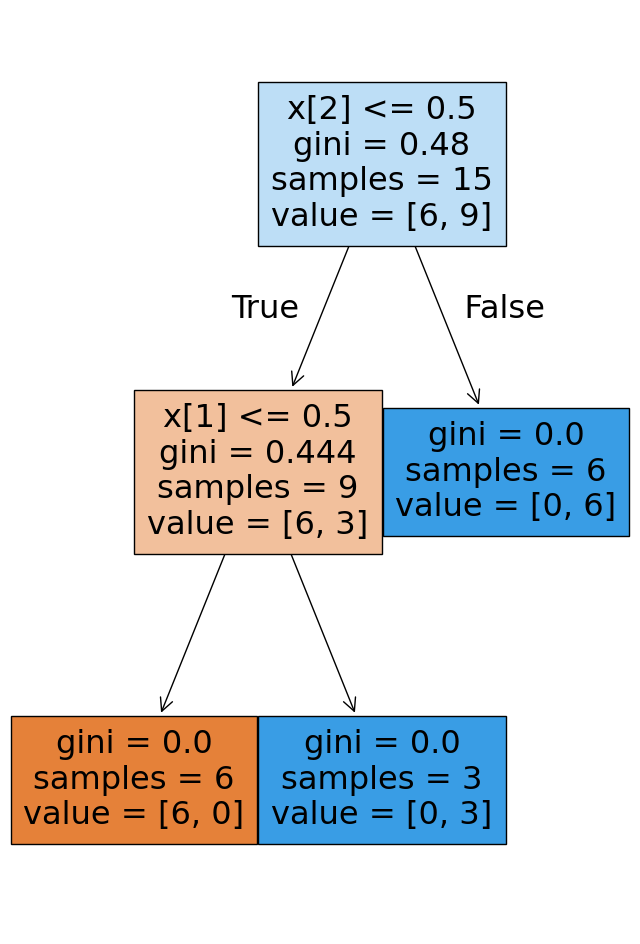

In [26]:
plt.figure(figsize=(8, 12))
plot_tree(clf, filled=True)
plt.show()

## part four : 自助搜集表格数据并完成分类任务